In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer, calculate_kmo
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore

In [3]:
# Set up file paths
os.chdir('/Users/nsusser/Desktop/Github/happyDB/')

# psych items and factors
df_main = pd.read_csv('data/final data - main.csv', encoding='latin1').sort_values(by='hmid').reset_index(drop=True)

# situational items
df_other = pd.read_csv('data/final data - other vars.csv', encoding='latin1').drop_duplicates(subset='hmid', keep='first')
df_other = df_other[df_other['hmid'].isin(set(list(df_main['hmid'])))].sort_values(by='hmid').reset_index(drop=True)
df_other.to_csv('data/filtered final data - other vars.csv', index=False)

/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_79446/1925872115.py:8: DtypeWarning: Columns (24,25,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_other = pd.read_csv('data/final data - other vars.csv', encoding='latin1').drop_duplicates(subset='hmid', keep='first')


In [4]:
predictor_cols = list(df_other.columns[10:])

correlation_results = []

# Human-readable factor names
factor_label_map = {
    "Factor 1": "Positive Emotions",
    "Factor 2": "Meaning and Mastery",
    "Factor 3": "Negative attitudes toward life",
    "Factor 4": "Close and Deep Relationships",
    "Factor 5": "Prosocial Behavior-Empathy for suffering",
    "Factor 6": "Engagement",
    "Factor 7": "Health",
    "Factor 8": "Autonomy",
    "Factor 9": "Vitality",
    "Factor 10": "Community & Belonging",
    "Factor 11": "Learning and Growth",
    "Factor 12": "Negative Emotions",
    "Factor 13": "Emotional Stability",
    "Factor 14": "Loneliness/Independence",
    "Factor 15": "Supportive Relationships",
    "Factor 16": "Autonomy-Engagement",
    "Factor 17": "Life Satisfaction",
    "Factor 18": "Trusting and Respectfully Relationships",
    "Factor 19": "Negative feelings toward self",
    "Factor 20": "Optimism",
    "Factor 21": "Resilience"
}

# Iterate over factors and compute top correlations
for fac in range(1, 22):
    factor_col = 'Factor_' + str(fac)
    readable_name = factor_label_map[f"Factor {fac}"]
    
    correlations = {}
    for col in predictor_cols:
        numeric_data = pd.to_numeric(df_other[col], errors='coerce')
        valid_indices = numeric_data.notna() & df_main[factor_col].notna()
        correlations[col] = df_main.loc[valid_indices, factor_col].corr(numeric_data.loc[valid_indices])
    
    top_5 = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
    
    print(f"FACTOR {fac} — {readable_name}")
    for col, corr in top_5:
        print(f"{col}: {corr}")
    print()
    
    for col, corr in top_5:
        correlation_results.append({
            "Factor": readable_name,
            "Predictor": col,
            "Correlation": corr
        })

# Create DataFrame and save
correlation_results_df = pd.DataFrame(correlation_results)
correlation_results_df.to_csv("factor_predictor_correlations.csv", index=False)


FACTOR 1 — Positive Emotions
positivity: 0.7295053906455742
self: 0.4986365892736391
certainty: 0.4452383857764804
episodictdetail: 0.43468047534222704
internalstimuli: 0.41293973089993874

FACTOR 2 — Meaning and Mastery
agency: 0.6075035360736433
duty: 0.5784280135106934
analyticity: 0.5321611738270448
intellect: 0.5214842652573101
goal - personal growth: 0.4351408434255529

FACTOR 3 — Negative attitudes toward life
negativity: 0.7185660559939087
adversity: 0.6045968777147893
emotion - satisfaction: -0.44587615363400906
emotion - joy: -0.4434087377458882
emotion - awkwardness: 0.43543933825424547

FACTOR 4 — Close and Deep Relationships
sociality: 0.8528301047854122
other: 0.7628746479612429
goal - friendship: 0.38243825001152926
goal - family: 0.3818665939464754
socialcontext - romantic: 0.377028417474413

FACTOR 5 — Prosocial Behavior-Empathy for suffering
moralevaluation: 0.5689395729517975
duty: 0.3077174913213904
other: 0.2735474991291317
goal - receiving from others: 0.273308807

In [5]:
# Initialize an empty DataFrame to store correlation results
correlation_matrix = pd.DataFrame(index=[f'Factor_{i}' for i in range(1, 22)], columns=predictor_cols)

# Iterate over factors and calculate correlations
for fac in range(1, 22):
    for col in predictor_cols:
        numeric_data = pd.to_numeric(df_other[col], errors='coerce')  # Convert to numeric, handling errors
        valid_indices = numeric_data.notna() & df_main[f'Factor_{fac}'].notna()  # Find valid indices
        correlation = df_main.loc[valid_indices, f'Factor_{fac}'].corr(numeric_data.loc[valid_indices])
        correlation_matrix.loc[f'Factor_{fac}', col] = correlation

# Convert to numeric and fill NaNs with 0 for clean output
correlation_matrix = correlation_matrix.apply(pd.to_numeric, errors='coerce').fillna(0)
correlation_matrix.to_csv('analysis_data/correlation_matrix.csv')

In [6]:
# select columns to use as predictors
#NOTE THAT FILL ZERO IS NOT THE RIGHT CHOICE  // ZSCORE ALL COLS AND THEN FILLNA WITH 0
predictors = df_other[predictor_cols].apply(pd.to_numeric, errors='coerce') 

# Apply Z-score standardization
predictors = predictors.apply(zscore, nan_policy='omit')

# handle NA values
predictors = predictors.fillna(0)
for fac in range(1,22):
    # split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(predictors, df_main['Factor_' + str(fac)], test_size=0.2, random_state=42)

    # train ridge regression model
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)

    # make predictions
    predictions = ridge.predict(X_test)
    # calculate and print out-of-sample mse and correlation
    mse = mean_squared_error(y_test, predictions)
    correlation = pd.Series(predictions).corr(pd.Series(y_test.values))
    print("FACTOR", fac)
    print(f"Out-of-sample MSE: {mse}")
    print(f"Out-of-sample correlation: {correlation}")
    print()
    print()

FACTOR 1
Out-of-sample MSE: 0.30268279368875184
Out-of-sample correlation: 0.8347043024494601


FACTOR 2
Out-of-sample MSE: 0.26745291777919683
Out-of-sample correlation: 0.8517282477081235


FACTOR 3
Out-of-sample MSE: 0.3021793883419811
Out-of-sample correlation: 0.8267953111881232


FACTOR 4
Out-of-sample MSE: 0.19661247995067535
Out-of-sample correlation: 0.893311401801927


FACTOR 5
Out-of-sample MSE: 0.39804705155699943
Out-of-sample correlation: 0.746503452891738


FACTOR 6
Out-of-sample MSE: 0.3808377746870886
Out-of-sample correlation: 0.7625833408668867


FACTOR 7
Out-of-sample MSE: 0.4868380599931836
Out-of-sample correlation: 0.6724788565667212


FACTOR 8
Out-of-sample MSE: 0.41352599545594537
Out-of-sample correlation: 0.7318793282262476


FACTOR 9
Out-of-sample MSE: 0.6317966365607426
Out-of-sample correlation: 0.540048233329204


FACTOR 10
Out-of-sample MSE: 0.43300216710080397
Out-of-sample correlation: 0.6925898983878814


FACTOR 11
Out-of-sample MSE: 0.490202852150318

In [7]:
# select columns to use as predictors
#NOTE THAT FILL ZERO IS NOT THE RIGHT CHOICE  // ZSCORE ALL COLS AND THEN FILLNA WITH 0
predictors = df_other[predictor_cols].apply(pd.to_numeric, errors='coerce') 

# Apply Z-score standardization
predictors = predictors.apply(zscore, nan_policy='omit')

# handle NA values
predictors = predictors.fillna(0)
for fac in range(1,22):
    # split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(predictors, df_main['Factor_' + str(fac)], test_size=0.2, random_state=42)

    # train ridge regression model
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)

    # make predictions
    predictions = ridge.predict(X_test)
    # calculate and print out-of-sample mse and correlation
    mse = mean_squared_error(y_test, predictions)
    correlation = pd.Series(predictions).corr(pd.Series(y_test.values))
    print("FACTOR", fac)
    print(f"Out-of-sample MSE: {mse}")
    print(f"Out-of-sample correlation: {correlation}")
    print()
    print()

FACTOR 1
Out-of-sample MSE: 0.30268279368875184
Out-of-sample correlation: 0.8347043024494601


FACTOR 2
Out-of-sample MSE: 0.26745291777919683
Out-of-sample correlation: 0.8517282477081235


FACTOR 3
Out-of-sample MSE: 0.3021793883419811
Out-of-sample correlation: 0.8267953111881232


FACTOR 4
Out-of-sample MSE: 0.19661247995067535
Out-of-sample correlation: 0.893311401801927


FACTOR 5
Out-of-sample MSE: 0.39804705155699943
Out-of-sample correlation: 0.746503452891738


FACTOR 6
Out-of-sample MSE: 0.3808377746870886
Out-of-sample correlation: 0.7625833408668867


FACTOR 7
Out-of-sample MSE: 0.4868380599931836
Out-of-sample correlation: 0.6724788565667212


FACTOR 8
Out-of-sample MSE: 0.41352599545594537
Out-of-sample correlation: 0.7318793282262476


FACTOR 9
Out-of-sample MSE: 0.6317966365607426
Out-of-sample correlation: 0.540048233329204


FACTOR 10
Out-of-sample MSE: 0.43300216710080397
Out-of-sample correlation: 0.6925898983878814


FACTOR 11
Out-of-sample MSE: 0.490202852150318

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Set working directory
os.chdir('/Users/nsusser/Desktop/Github/happyDB/')

# Merge the datasets on the unique identifier "hmid"
df_merged = pd.merge(df_main, df_other, on='hmid', how='inner')


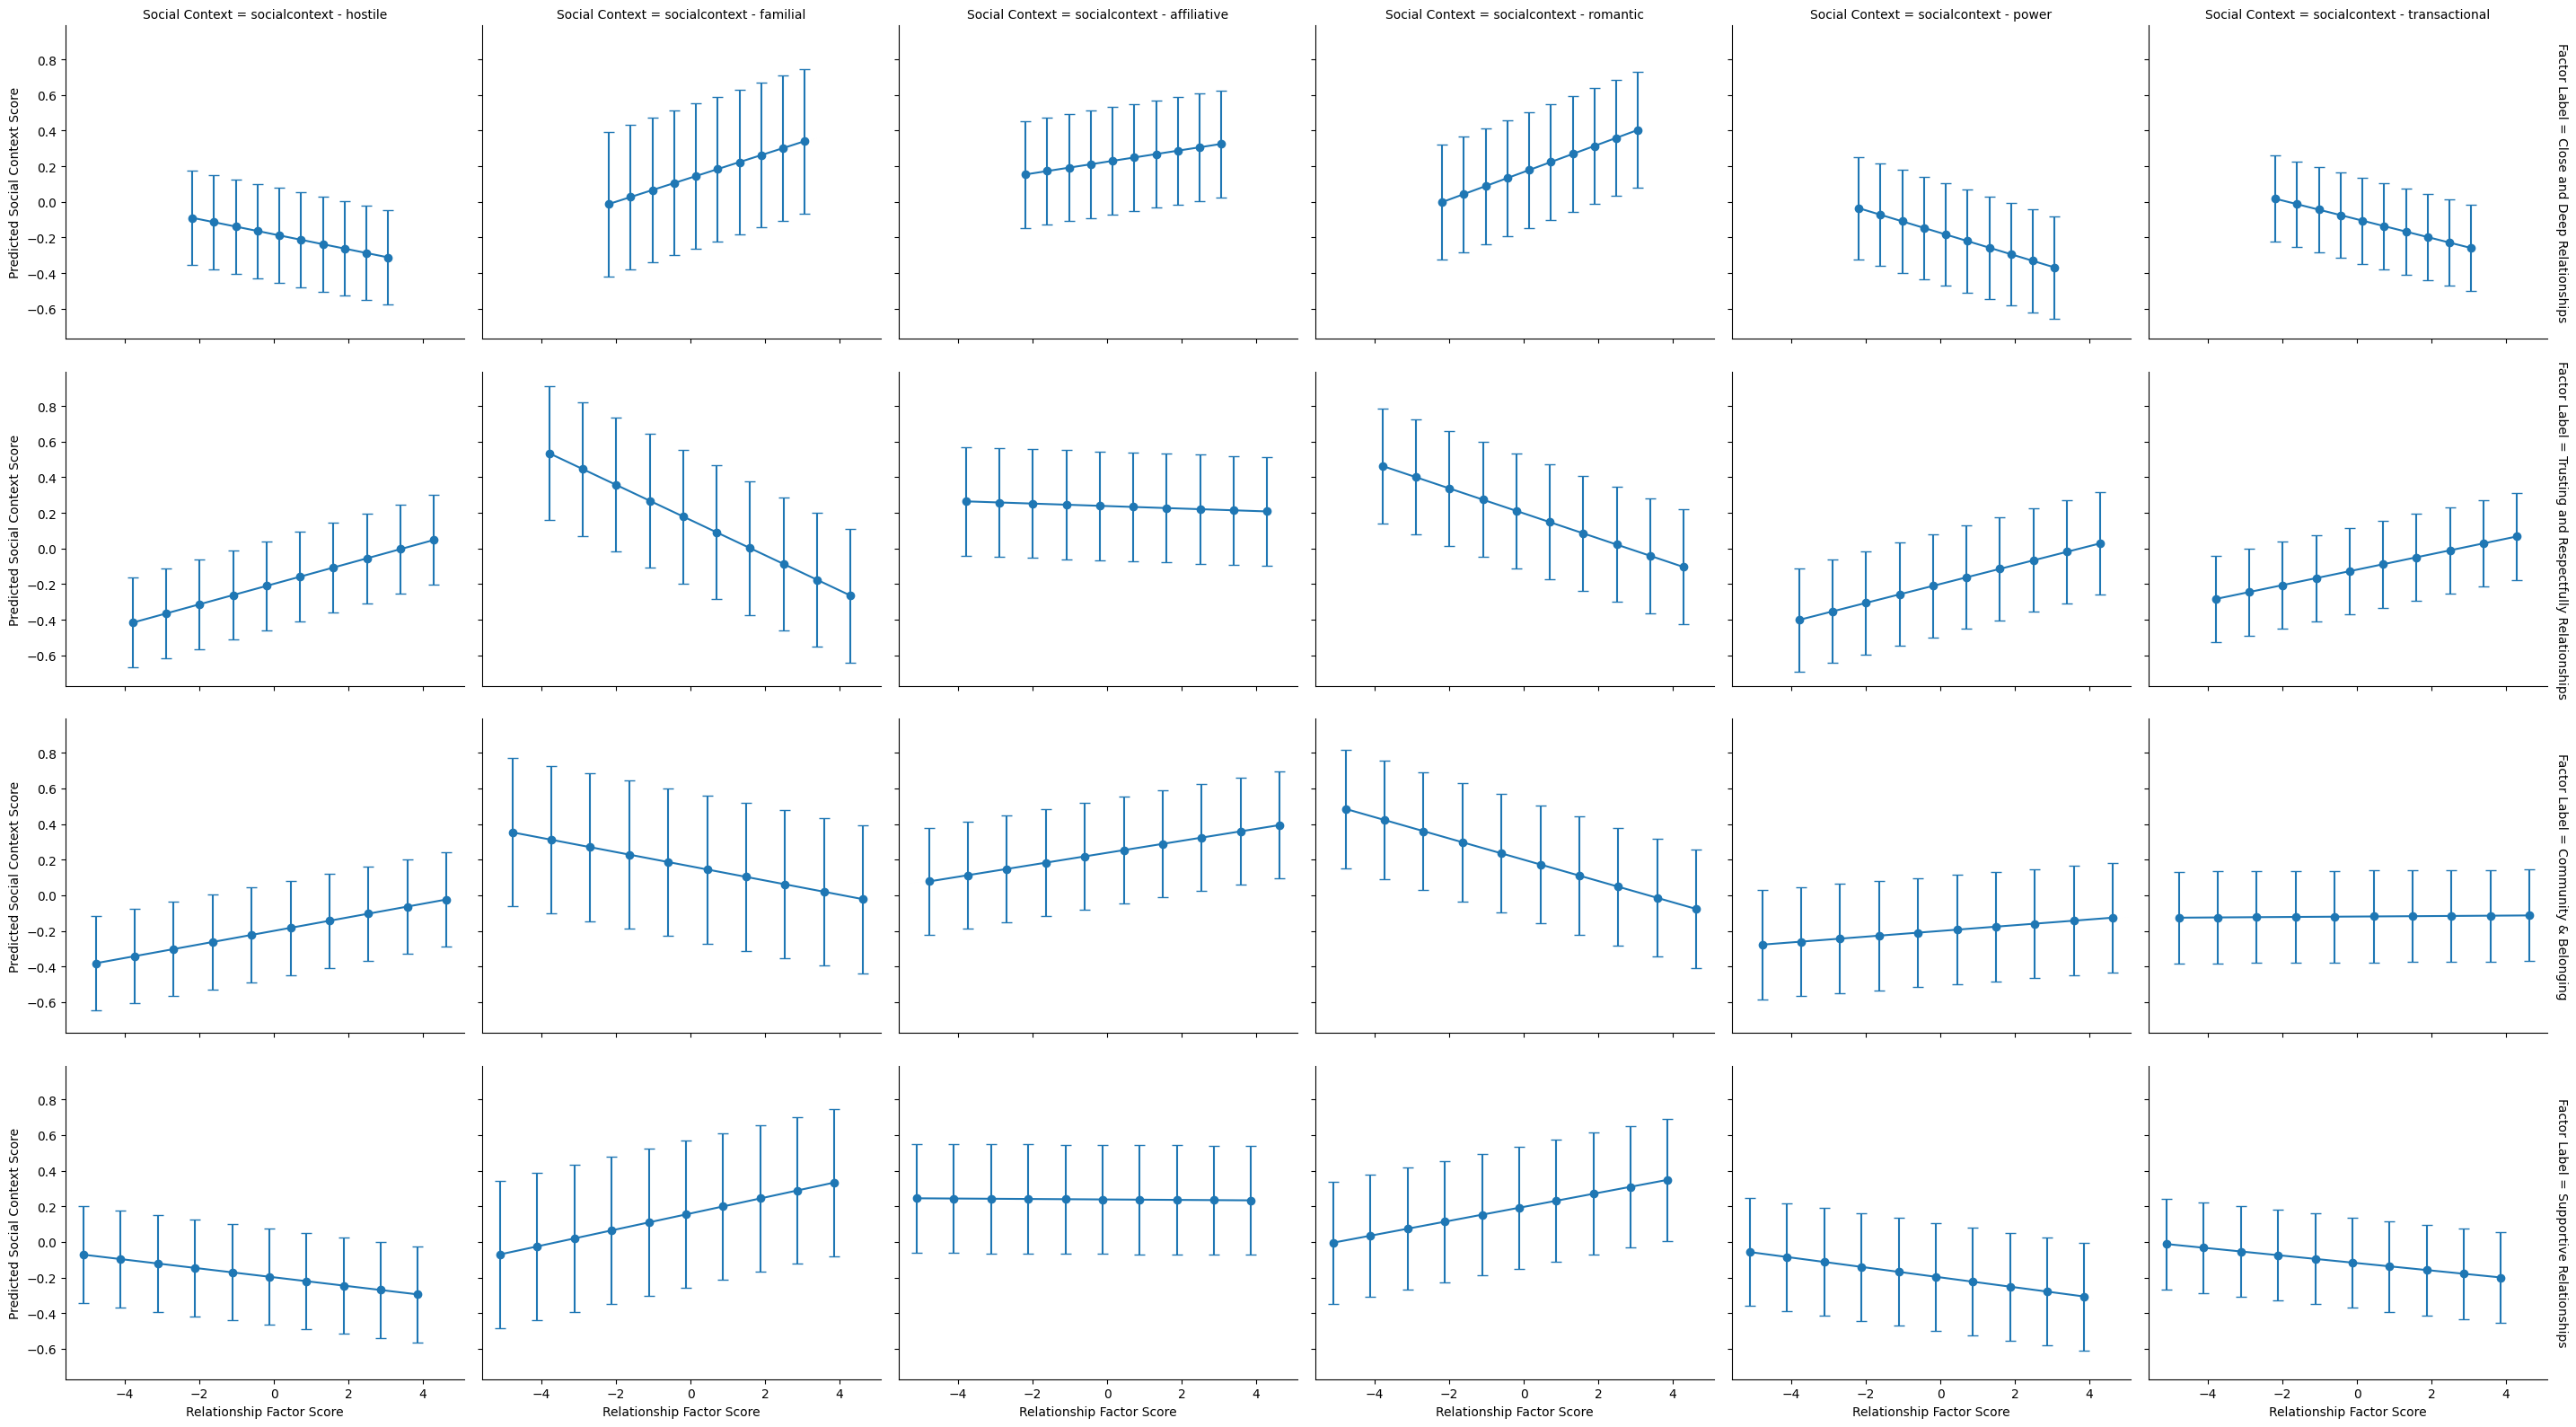

In [9]:

# Define the relationship factors of interest with human-readable labels.
# Since these are already standardized, we use them directly.
relationship_factors = {
    "Close and Deep Relationships": "Factor_4",
    "Trusting and Respectfully Relationships": "Factor_18",
    "Community & Belonging": "Factor_10",
    "Supportive Relationships": "Factor_15"
}

# Define the social context variables (ensure these column names match your dataset)
socialcontext_cols = [
    "socialcontext - hostile",
    "socialcontext - familial",
    "socialcontext - affiliative",
    "socialcontext - romantic",
    "socialcontext - power",
    "socialcontext - transactional"
]

# Prepare a list to collect regression prediction grids and confidence intervals
grid_data_list = []

# Loop over each relationship factor and social context variable combination
for fac_label, factor_col in relationship_factors.items():
    for sc in socialcontext_cols:
        # Prepare the data for regression: select the factor and the social context variable; drop missing values
        temp_df = df_merged[[factor_col, sc]].dropna()
        X = temp_df[factor_col]
        y = temp_df[sc]
        # Add a constant term for the intercept
        X_const = sm.add_constant(X)
        
        # Fit a simple OLS regression model
        model = sm.OLS(y, X_const).fit()
        
        # Create a grid of relationship factor scores for prediction (10 evenly spaced points)
        x_grid = np.linspace(X.min(), X.max(), 10)
        X_new = sm.add_constant(x_grid)
        pred = model.get_prediction(X_new)
        pred_summary = pred.summary_frame(alpha=0.05)  # 95% confidence intervals
        
        # Store the predictions and confidence intervals in a DataFrame
        temp_grid = pd.DataFrame({
            "Relationship Factor": x_grid,
            "Predicted SC": pred_summary["mean"],
            "Lower CI": pred_summary["obs_ci_lower"],
            "Upper CI": pred_summary["obs_ci_upper"],
            "Factor Label": fac_label,
            "Social Context": sc
        })
        grid_data_list.append(temp_grid)

# Concatenate all grid data into one DataFrame
grid_data = pd.concat(grid_data_list, ignore_index=True)

# Function to plot error bars for each facet
def plot_errorbars(data, color, **kwargs):
    # Compute asymmetric error bar lengths
    yerr_lower = data["Predicted SC"] - data["Lower CI"]
    yerr_upper = data["Upper CI"] - data["Predicted SC"]
    yerr = [yerr_lower, yerr_upper]
    plt.errorbar(
        data["Relationship Factor"],
        data["Predicted SC"],
        yerr=yerr,
        fmt='-o',
        color=color,
        capsize=4
    )

# Create a FacetGrid with one row per relationship factor and one column per social context variable
g = sns.FacetGrid(
    grid_data, 
    row="Factor Label", 
    col="Social Context", 
    height=4, 
    aspect=1.2, 
    margin_titles=True
)
g.map_dataframe(plot_errorbars)
g.set_axis_labels("Relationship Factor Score", "Predicted Social Context Score")
g.set_titles("{row_name} — {col_name}")
plt.tight_layout()
plt.show()

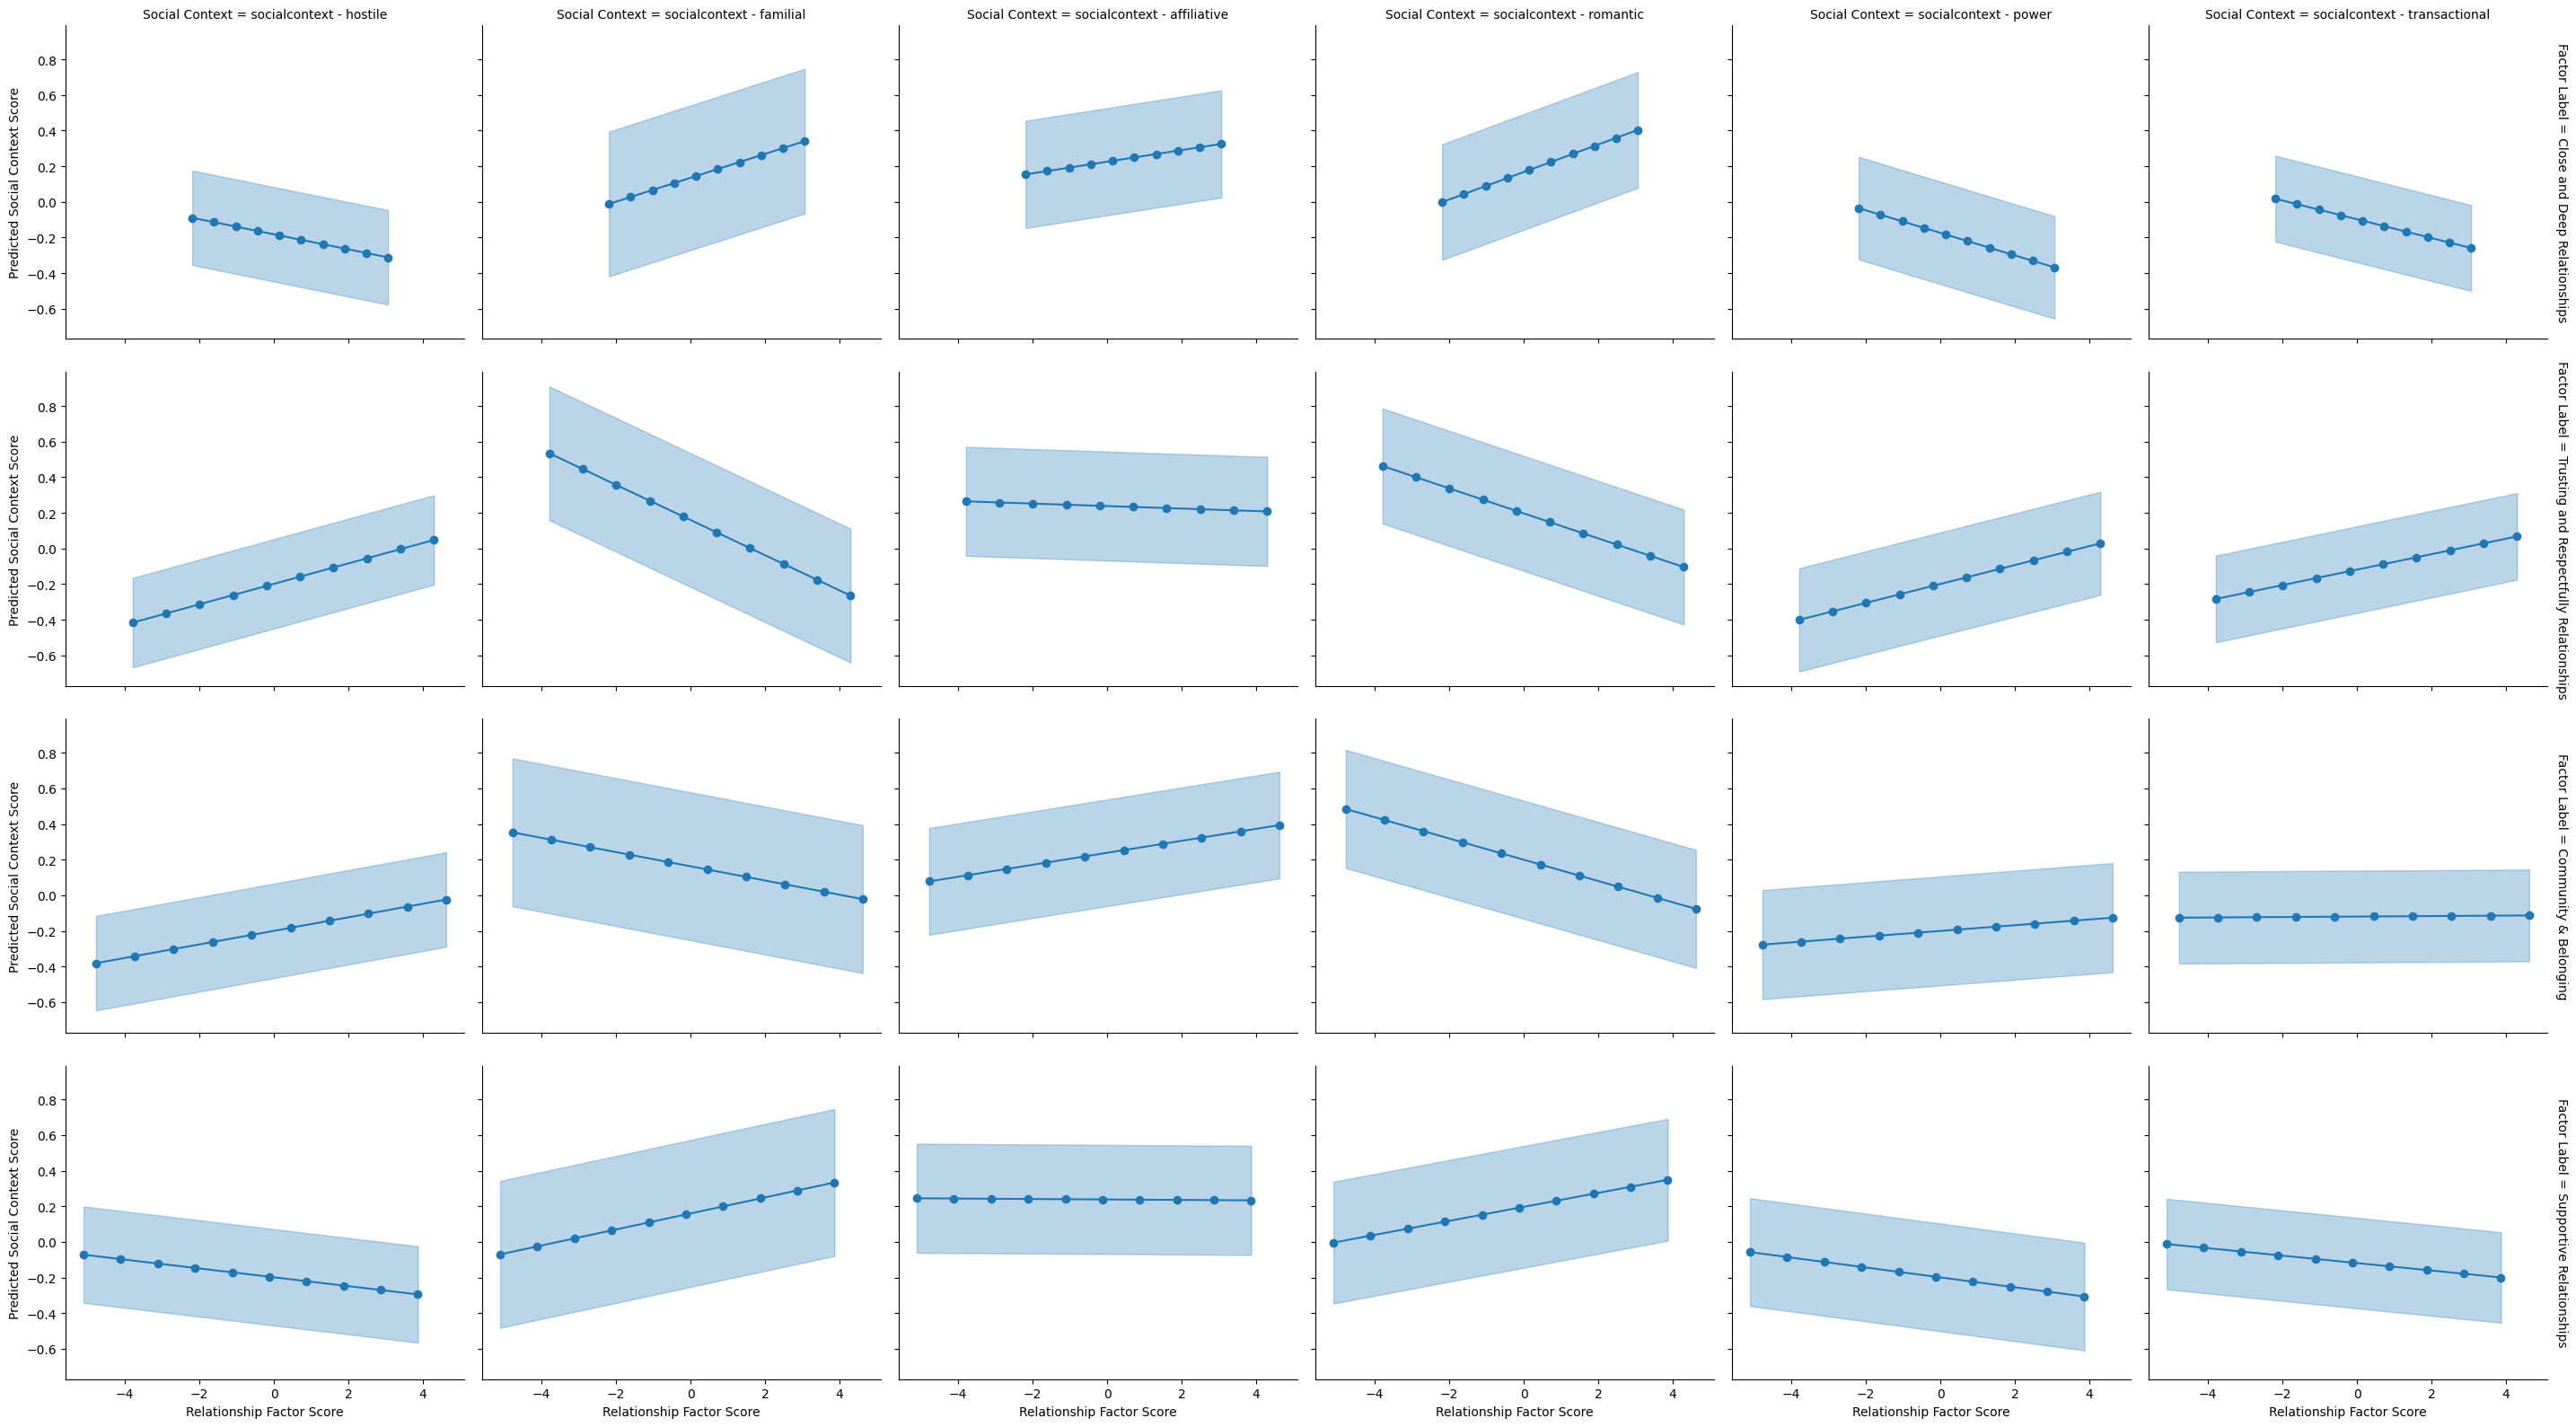

In [10]:
# Function to plot a regression line with a shaded confidence interval
def plot_shaded_region(data, color, **kwargs):
    # Sort the data by Relationship Factor for a clean line
    data = data.sort_values("Relationship Factor")
    plt.plot(data["Relationship Factor"], data["Predicted SC"], '-o', color=color)
    plt.fill_between(
        data["Relationship Factor"],
        data["Lower CI"],
        data["Upper CI"],
        color=color,
        alpha=0.3
    )

# Create a FacetGrid with one row per relationship factor and one column per social context variable
g = sns.FacetGrid(
    grid_data, 
    row="Factor Label", 
    col="Social Context", 
    height=4, 
    aspect=1.2, 
    margin_titles=True
)

# Map the custom function to the FacetGrid
g.map_dataframe(plot_shaded_region)
g.set_axis_labels("Relationship Factor Score", "Predicted Social Context Score")
g.set_titles("{row_name} — {col_name}")
plt.tight_layout()
plt.show()


/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_79446/732714419.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "P-Value": model.pvalues[1],
/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_79446/732714419.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "P-Value": model.pvalues[1],
/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_79446/732714419.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

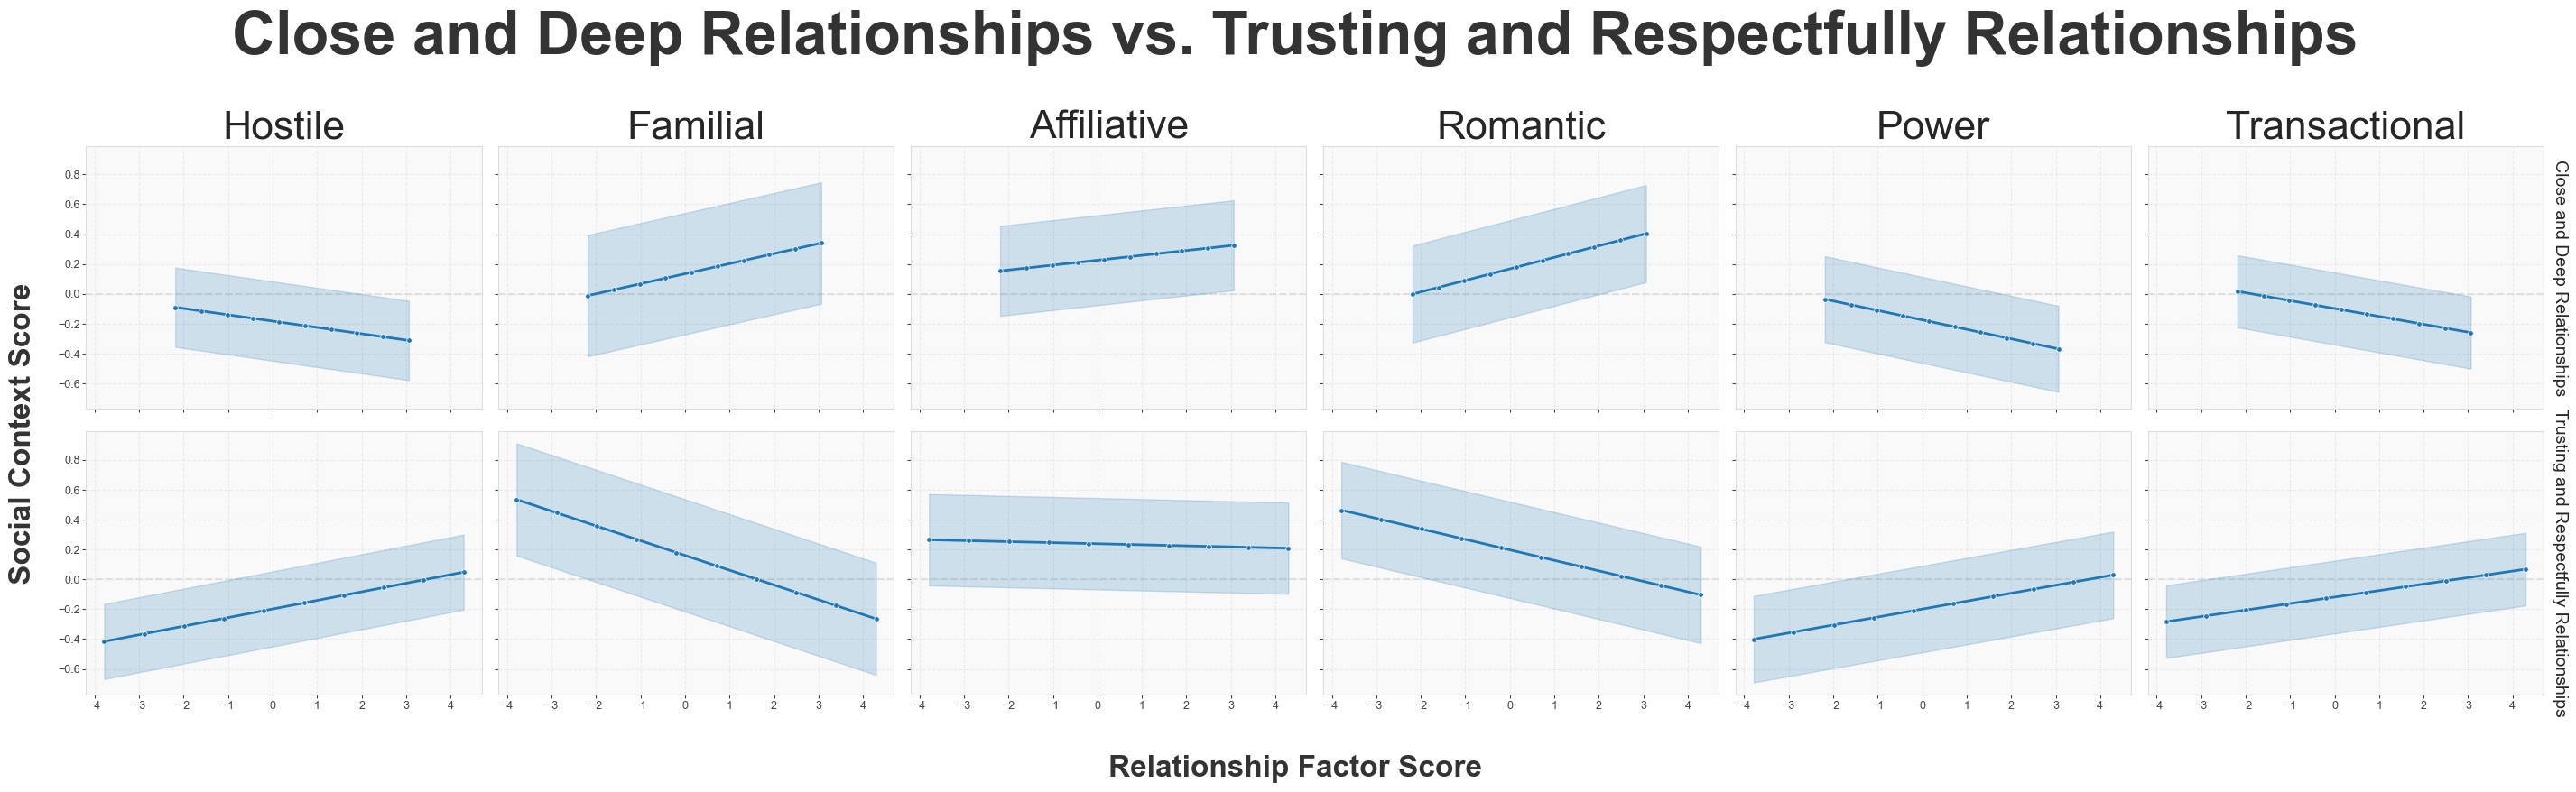

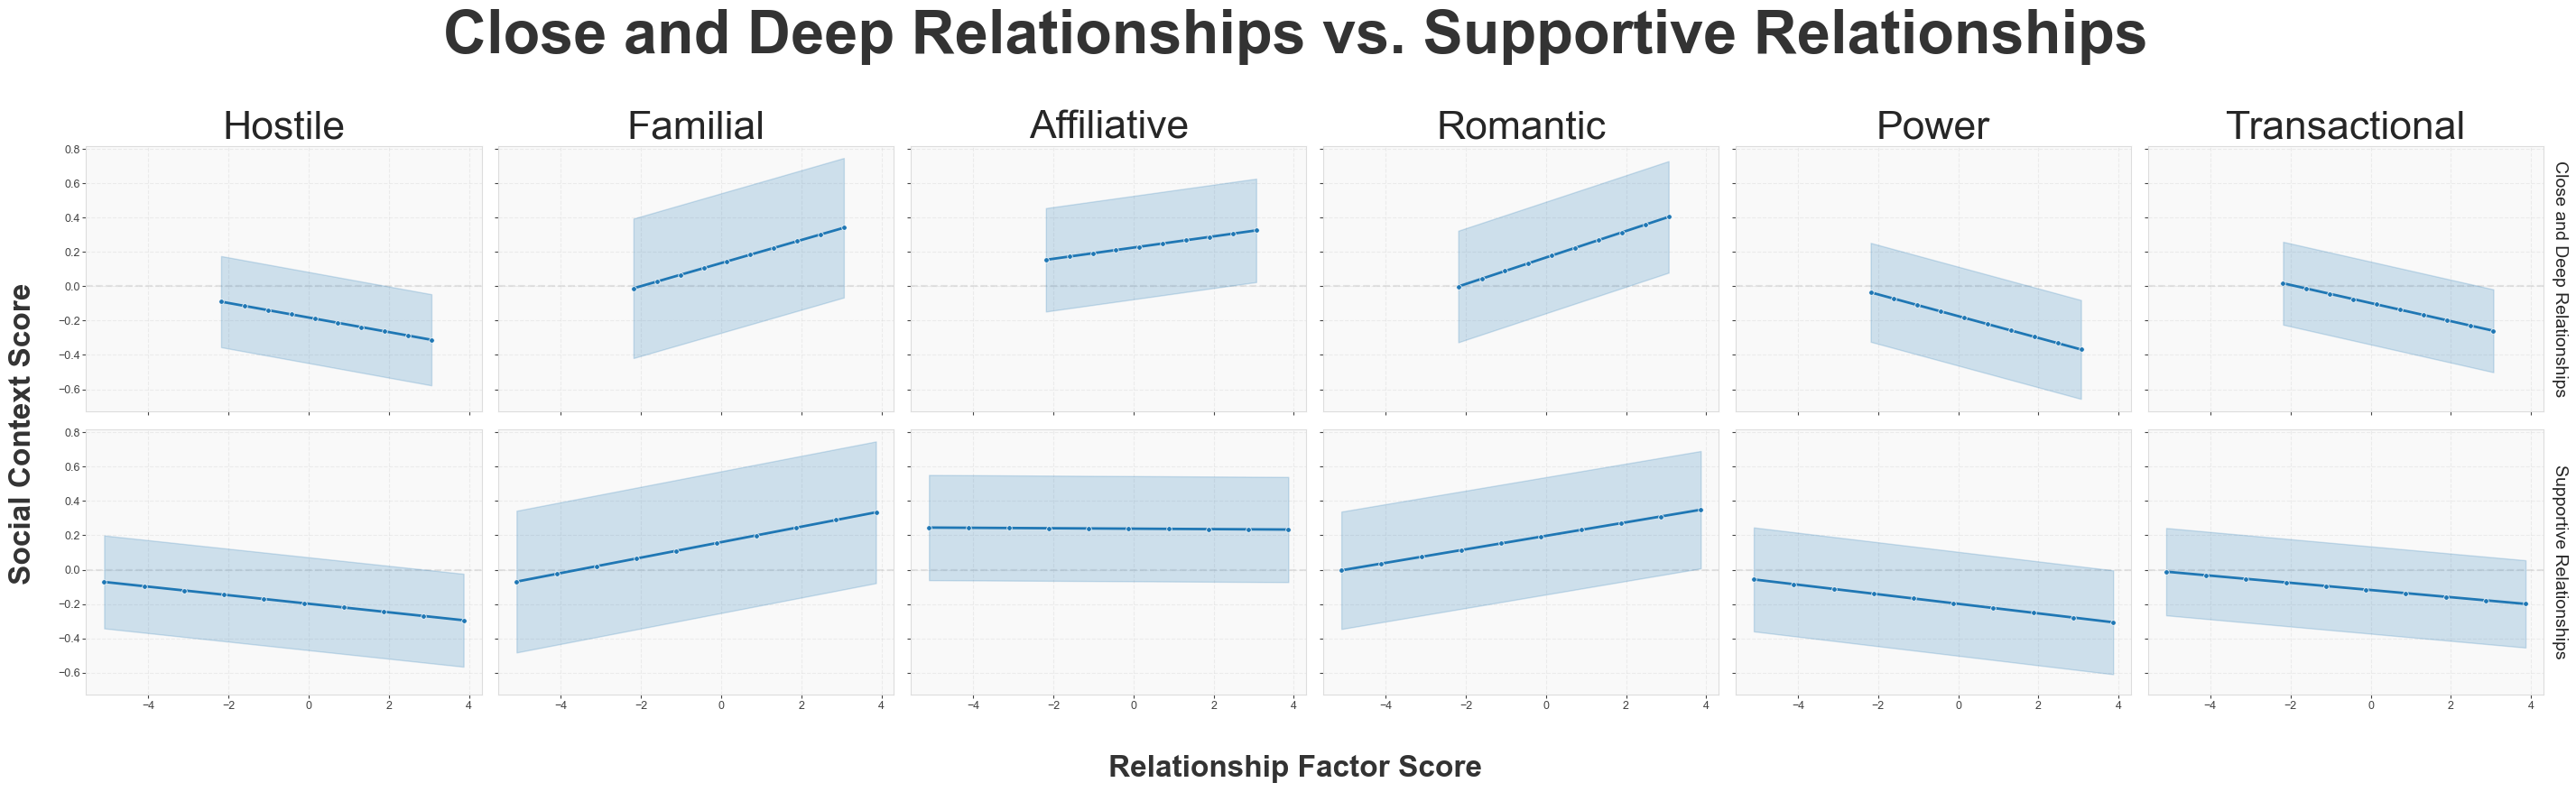

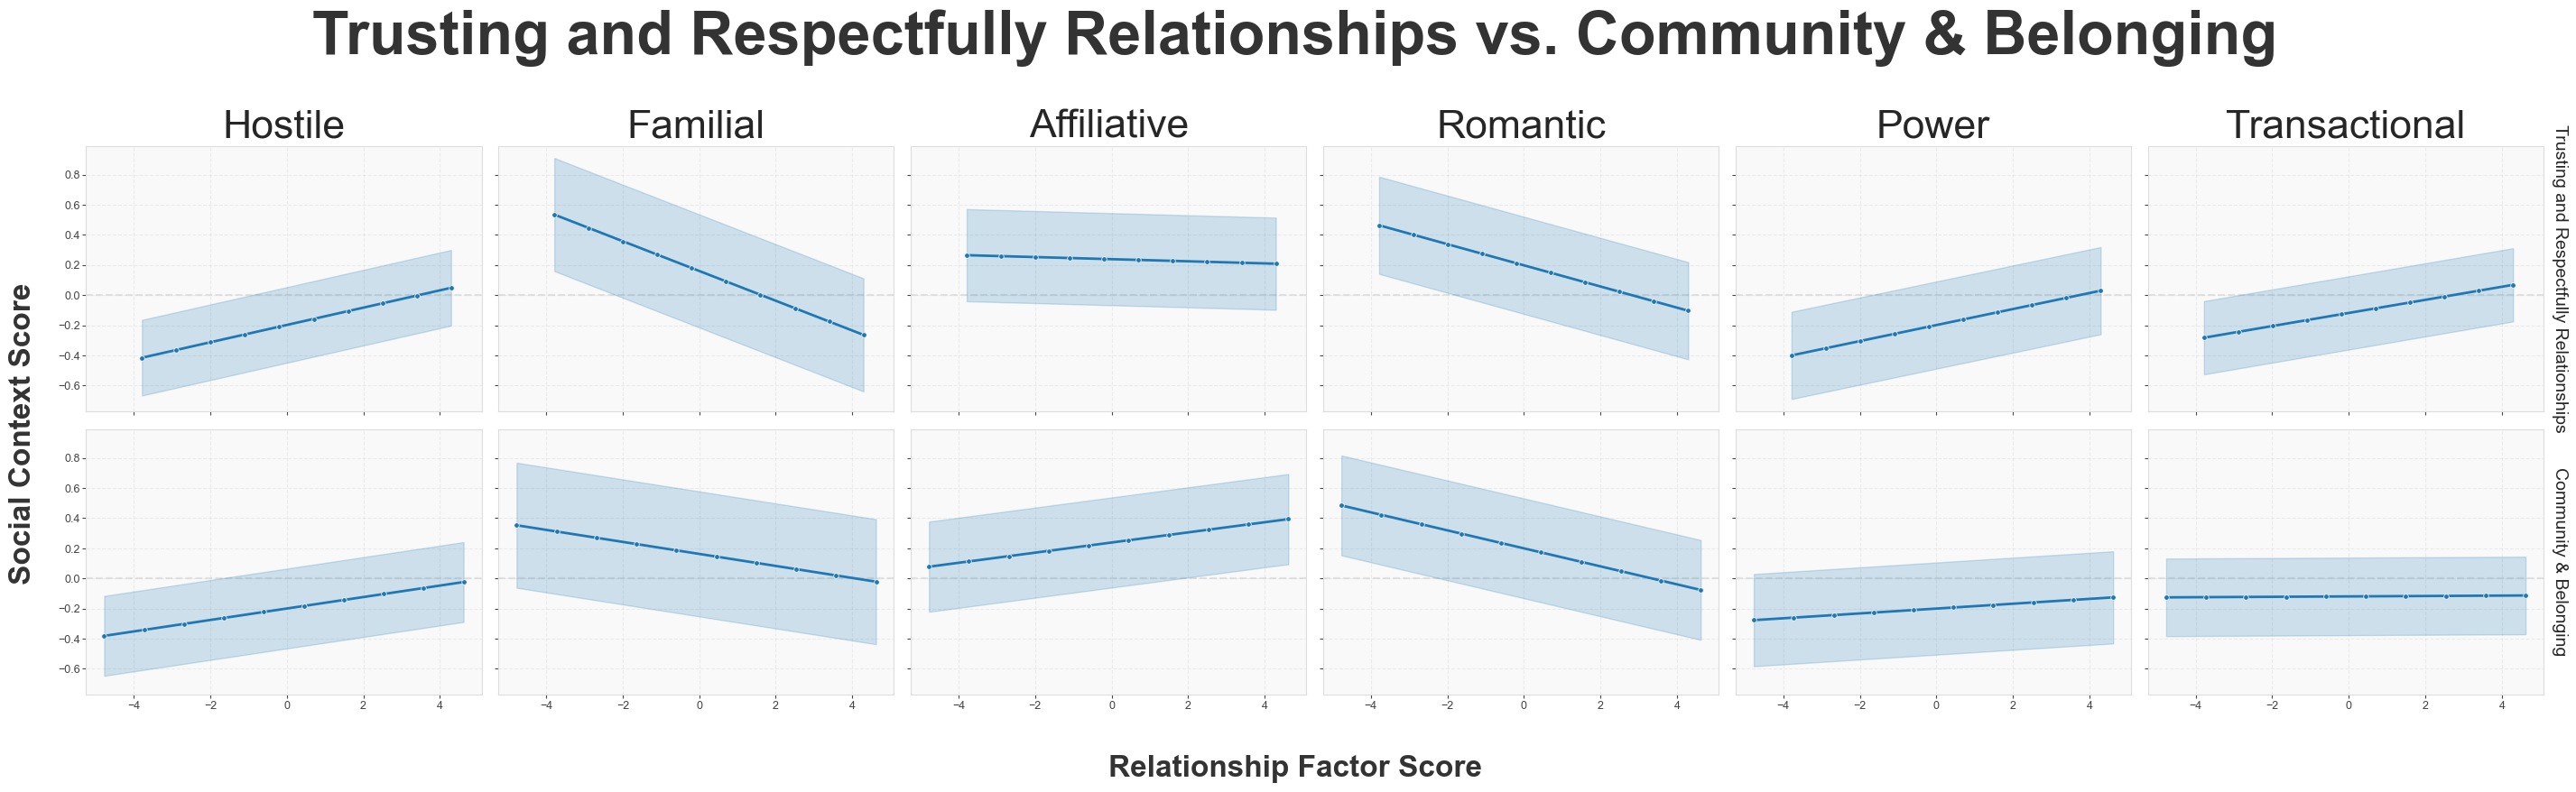

In [41]:
# Define the relationship factors of interest with human-readable labels.
# (Assuming factor scores are already standardized.)
relationship_factors = {
    "Close and Deep Relationships": "Factor_4",
    "Trusting and Respectfully Relationships": "Factor_18",
    "Community & Belonging": "Factor_10",
    "Supportive Relationships": "Factor_15"
}

# Define the social context variables (ensure these column names match your dataset)
socialcontext_cols = [
    "socialcontext - hostile",
    "socialcontext - familial",
    "socialcontext - affiliative",
    "socialcontext - romantic",
    "socialcontext - power",
    "socialcontext - transactional"
]

# NEW: Prepare list for p-value results
pval_results = []

# Create prediction grids for each combination of relationship factor and social context variable.
grid_data_list = []
for fac_label, factor_col in relationship_factors.items():
    for sc in socialcontext_cols:
        temp_df = df_merged[[factor_col, sc]].dropna()
        X = temp_df[factor_col]
        y = temp_df[sc]
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()


        # NEW: Save p-value and R-squared
        pval_results.append({
            "Factor Label": fac_label,
            "Social Context": sc,
            "P-Value": model.pvalues[1],
            "R-squared": model.rsquared
        })

        # Create a grid of 10 points for prediction.
        x_grid = np.linspace(X.min(), X.max(), 10)
        X_new = sm.add_constant(x_grid)
        pred = model.get_prediction(X_new)
        pred_summary = pred.summary_frame(alpha=0.05)
        temp_grid = pd.DataFrame({
            "Relationship Factor": x_grid,
            "Predicted SC": pred_summary["mean"],
            "Lower CI": pred_summary["obs_ci_lower"],
            "Upper CI": pred_summary["obs_ci_upper"],
            "Factor Label": fac_label,
            "Social Context": sc
        })
        grid_data_list.append(temp_grid)

# Concatenate all prediction grids into one DataFrame.
grid_data = pd.concat(grid_data_list, ignore_index=True)

# Create a new column for short social context names (the part after the hyphen),
# with the first letter capitalized.
grid_data["SC_short"] = grid_data["Social Context"].apply(
    lambda x: x.split(" - ")[1].capitalize() if " - " in x else x.capitalize()
)

# Set the default style for all plots
plt.style.use('seaborn-v0_8-whitegrid')  # Modern clean style with grid
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['axes.labelcolor'] = '#333333'
plt.rcParams['axes.edgecolor'] = '#666666'
plt.rcParams['xtick.color'] = '#333333'
plt.rcParams['ytick.color'] = '#333333'

# Define a custom color palette - professional looking blues and teals
custom_palette = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728', '#9467bd', '#8c564b']

# Define a custom plotting function that draws the regression line with a shaded confidence region.
def plot_shaded_region(data, color, **kwargs):
    data = data.sort_values("Relationship Factor")
    # Use a smoother line with fewer markers
    plt.plot(data["Relationship Factor"], data["Predicted SC"], 
             marker='o', markersize=4, color=color, lw=2, 
             markeredgecolor='white', markeredgewidth=0.5)
    
    # Add shaded confidence interval with slightly more transparency
    plt.fill_between(
        data["Relationship Factor"],
        data["Lower CI"],
        data["Upper CI"],
        color=color,
        alpha=0.2  # More subtle transparency
    )
    
    # Add a subtle horizontal line at y=0 for reference if it's in range
    y_min, y_max = plt.ylim()
    if y_min <= 0 <= y_max:
        plt.axhline(y=0, color='#cccccc', linestyle='--', alpha=0.5, zorder=0)

# Function to customize the appearance of each subplot
def customize_subplot(ax, row_name=None):
    # Add subtle grid
    ax.grid(True, linestyle='--', alpha=0.3, color='#cccccc')
    
    # Add subtle box around the plot
    for spine in ax.spines.values():
        spine.set_edgecolor('#dddddd')
        spine.set_linewidth(0.8)
    
    # Make tick marks shorter and lighter
    ax.tick_params(axis='both', which='major', labelsize=9, length=3, width=0.8, 
                   colors='#444444', pad=2)
    
    # If it's a specific row, add a background highlight
    if row_name:
        ax.set_facecolor('#f9f9f9')  # Very light gray background

# ---------------------------
# Plot 1: Compare Close and Deep Relationships vs. Trusting and Respectfully Relationships
# ---------------------------
desired_factors_1 = ["Close and Deep Relationships", "Trusting and Respectfully Relationships"]
plot_data1 = grid_data[grid_data["Factor Label"].isin(desired_factors_1)]

g1 = sns.FacetGrid(
    plot_data1,
    row="Factor Label",
    col="SC_short",
    height=3.8,  # Slightly smaller for better proportions
    aspect=1.25,
    margin_titles=True,
    sharey=True,
    despine=False  # Keep all spines
)

# Use the plotting function to draw the regression line with a shaded confidence region.
g1.map_dataframe(plot_shaded_region)

# Set custom titles
g1.set_titles(row_template="{row_name}", col_template="{col_name}", size=14)

# Update only the column titles (typically displayed on the top row) by iterating over that row.
# Note: If your grid has only one row, g3.axes might be a 1D array.
if g1.axes.ndim == 1:
    top_axes = g1.axes
else:
    top_axes = g1.axes[0]  # first row of axes

for ax in top_axes:
    # Retrieve the current title and reassign it with the new font size.
    current_title = ax.get_title()
    ax.set_title(current_title, fontsize=32)

# Add an overall title to the figure
g1.fig.suptitle('Close and Deep Relationships vs. Trusting and Respectfully Relationships', 
               fontsize=48, y=1.12, fontweight='bold', color='#333333')

# Customize each subplot
for i, ax in enumerate(g1.axes.flatten()):
    ax.invert_yaxis()  # retain inversion if needed
    row_name = desired_factors_1[i // len(socialcontext_cols)] if i < len(g1.axes.flatten()) else None
    customize_subplot(ax, row_name)

# Add a shared y-axis label (rotated, on the left)
g1.fig.text(
    0.00, 0.5,  # Move x a bit further left to avoid overlapping
    'Social Context Score',
    va='center',
    rotation='vertical',
    fontsize=24,
    fontweight='bold',
    color='#333333'
)

# Add a shared x-axis label (centered below)
g1.fig.text(
    0.5, 0.00,  # Push lower to give it space
    'Relationship Factor Score',
    ha='center',
    fontsize=24,
    fontweight='bold',
    color='#333333'
)


plt.tight_layout()
plt.subplots_adjust(top=0.92, left=0.03, bottom=0.12)
plt.show()


# ---------------------------
# Plot 2: Compare Close and Deep Relationships vs. Supportive Relationships
# ---------------------------
desired_factors_2 = ["Close and Deep Relationships", "Supportive Relationships"]
plot_data2 = grid_data[grid_data["Factor Label"].isin(desired_factors_2)]
g2 = sns.FacetGrid(
    plot_data2,
    row="Factor Label",
    col="SC_short",
    height=3.8,
    aspect=1.25,
    margin_titles=True,
    despine=False
)
g2.map_dataframe(plot_shaded_region)

# Set custom titles
g2.set_titles(row_template="{row_name}", col_template="{col_name}", size=14)

# Update only the column titles (typically displayed on the top row) by iterating over that row.
# Note: If your grid has only one row, g3.axes might be a 1D array.
if g2.axes.ndim == 1:
    top_axes = g2.axes
else:
    top_axes = g2.axes[0]  # first row of axes

for ax in top_axes:
    # Retrieve the current title and reassign it with the new font size.
    current_title = ax.get_title()
    ax.set_title(current_title, fontsize=32)

# Add an overall title
g2.fig.suptitle('Close and Deep Relationships vs. Supportive Relationships', 
               fontsize=48, y=1.12, fontweight='bold', color='#333333')

# Customize each subplot
for i, ax in enumerate(g2.axes.flatten()):
    ax.invert_yaxis()  # retain inversion if needed
    row_name = desired_factors_2[i // len(socialcontext_cols)] if i < len(g2.axes.flatten()) else None
    customize_subplot(ax, row_name)

# Add a shared y-axis label (rotated, on the left)
g2.fig.text(
    0.00, 0.5,  # Move x a bit further left to avoid overlapping
    'Social Context Score',
    va='center',
    rotation='vertical',
    fontsize=24,
    fontweight='bold',
    color='#333333'
)

# Add a shared x-axis label (centered below)
g2.fig.text(
    0.5, 0.00,  # Push lower to give it space
    'Relationship Factor Score',
    ha='center',
    fontsize=24,
    fontweight='bold',
    color='#333333'
)


plt.tight_layout()
plt.subplots_adjust(top=0.92, left=0.03, bottom=0.12)
plt.show()

# ---------------------------
# Plot 3: Compare Community & Belonging vs. Trusting and Respectfully Relationships
# ---------------------------
desired_factors_3 = ["Community & Belonging", "Trusting and Respectfully Relationships"]
plot_data3 = grid_data[grid_data["Factor Label"].isin(desired_factors_3)]
g3 = sns.FacetGrid(
    plot_data3,
    row="Factor Label",
    col="SC_short",
    height=3.8,
    aspect=1.25,
    margin_titles=True,
    despine=False
)
g3.map_dataframe(plot_shaded_region) 

# Set titles without a size argument so they keep their default styling.
g3.set_titles(row_template="{row_name}", col_template="{col_name}", size=14)

# Update only the column titles (typically displayed on the top row) by iterating over that row.
# Note: If your grid has only one row, g3.axes might be a 1D array.
if g3.axes.ndim == 1:
    top_axes = g3.axes
else:
    top_axes = g3.axes[0]  # first row of axes

for ax in top_axes:
    # Retrieve the current title and reassign it with the new font size.
    current_title = ax.get_title()
    ax.set_title(current_title, fontsize=32)

# Add an overall title
g3.fig.suptitle('Trusting and Respectfully Relationships vs. Community & Belonging', 
               fontsize=48, y=1.12, fontweight='bold', color='#333333')

# Customize each subplot
for i, ax in enumerate(g3.axes.flatten()):
    ax.invert_yaxis()  # retain inversion if needed
    row_name = desired_factors_3[i // len(socialcontext_cols)] if i < len(g3.axes.flatten()) else None
    customize_subplot(ax, row_name)

# Add a shared y-axis label (rotated, on the left)
g3.fig.text(
    0.00, 0.5,  # Move x a bit further left to avoid overlapping
    'Social Context Score',
    va='center',
    rotation='vertical',
    fontsize=24,
    fontweight='bold',
    color='#333333'
)

# Add a shared x-axis label (centered below)
g3.fig.text(
    0.5, 0.00,  # Push lower to give it space
    'Relationship Factor Score',
    ha='center',
    fontsize=24,
    fontweight='bold',
    color='#333333'
)


plt.tight_layout()
plt.subplots_adjust(top=0.92, left=0.03, bottom=0.12)
plt.show()

In [42]:
# Create DataFrame of p-values and model fit
pval_df = pd.DataFrame(pval_results)

# Create readable short social context names
pval_df["Social Context Short"] = pval_df["Social Context"].apply(
    lambda x: x.split(" - ")[1].capitalize() if " - " in x else x.capitalize()
)

# Add significance level stars based on p-value
def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

pval_df["Significance"] = pval_df["P-Value"].apply(significance_stars)

# Display the p-value summary table sorted by p-value
print("\n--- Regression Summary with P-Values and Significance ---\n")
print(pval_df.sort_values(by="P-Value").to_string(index=False))


--- Regression Summary with P-Values and Significance ---

                           Factor Label                Social Context       P-Value  R-squared Social Context Short Significance
           Close and Deep Relationships       socialcontext - hostile  0.000000e+00   0.069448              Hostile          ***
               Supportive Relationships      socialcontext - romantic  0.000000e+00   0.050184             Romantic          ***
               Supportive Relationships      socialcontext - familial  0.000000e+00   0.045324             Familial          ***
               Supportive Relationships       socialcontext - hostile  0.000000e+00   0.032621              Hostile          ***
                  Community & Belonging      socialcontext - romantic  0.000000e+00   0.106457             Romantic          ***
                  Community & Belonging   socialcontext - affiliative  0.000000e+00   0.044297          Affiliative          ***
                  Community & Belongi

In [49]:
# Step 1: Create a clean copy with short name replacing long one
pval_display_df = (
    pval_df
    .drop(columns=["Social Context"])  # drop long name
    .rename(columns={"Social Context Short": "Social Context"})  # rename short one
)

# Step 2: Reorder columns as requested
column_order = ["Factor Label", "Social Context", "P-Value", "R-squared", "Significance"]
pval_display_df = pval_display_df[column_order]

# Step 2: Ensure no duplicate columns (for styling to work)
assert pval_display_df.columns.duplicated().sum() == 0, "Duplicate column names found!"

# Step 3: Fancy styled table
styled_table = (
    pval_display_df
    .sort_values(by="P-Value")
    .style
    .set_caption("Regression Summary with P-Values and Significance</b>")
    .format({
        "P-Value": "{:.3e}",
        "R-squared": "{:.3f}"
    })
    .hide(axis="index")
    .set_table_styles([
        {"selector": "caption", "props": [("font-size", "18px"), ("font-weight", "bold"), ("color", "#333")]},
        {"selector": "th", "props": [("text-align", "center"), ("background-color", "#f0f0f0")]},
    ])
    .applymap(lambda val: "font-weight: bold; color: #d62728" if isinstance(val, str) and "***" in val else "")
    .set_properties(**{
        "text-align": "center",
        "font-size": "12px",
        "border": "1px solid #ccc",
        "padding": "6px"
    })
)

styled_table


/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_79446/2030628322.py:30: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda val: "font-weight: bold; color: #d62728" if isinstance(val, str) and "***" in val else "")


Factor Label,Social Context,P-Value,R-squared,Significance
Close and Deep Relationships,Hostile,0.000e+00,0.069,***
Supportive Relationships,Romantic,0.000e+00,0.050,***
Supportive Relationships,Familial,0.000e+00,0.045,***
Supportive Relationships,Hostile,0.000e+00,0.033,***
Community & Belonging,Romantic,0.000e+00,0.106,***
Community & Belonging,Affiliative,0.000e+00,0.044,***
Community & Belonging,Familial,0.000e+00,0.033,***
Community & Belonging,Hostile,0.000e+00,0.070,***
Supportive Relationships,Power,0.000e+00,0.033,***
Trusting and Respectfully Relationships,Power,0.000e+00,0.114,***


In [55]:
# Define groups of factor labels per plot
factor_pairs = [
    ("Close and Deep Relationships", "Trusting and Respectfully Relationships"),  # Plot 1
    ("Close and Deep Relationships", "Supportive Relationships"),                 # Plot 2
    ("Community & Belonging", "Trusting and Respectfully Relationships")          # Plot 3
]

# Optional: Set display formatting for clarity
pd.set_option("display.float_format", lambda x: f"{x:.3e}")

# Create one styled table per pair
styled_tables = []

for pair in factor_pairs:
    filtered_df = (
        pval_df[pval_df["Factor Label"].isin(pair)]
        .drop(columns=["Social Context"])
        .rename(columns={"Social Context Short": "Social Context"})
        .loc[:, ["Factor Label", "P-Value", "R-squared", "Social Context", "Significance"]]
        .sort_values(by="P-Value")
    )
    
    styled = (
        filtered_df
        .style
        .set_caption(
            f"Regression Summary with P-Values and Significance"
        )
        .format({
            "P-Value": "{:.3e}",
            "R-squared": "{:.3f}"
        })
        .hide(axis="index")
        .set_table_styles([
            {"selector": "caption", "props": [("font-size", "18px"), ("font-weight", "bold"), ("color", "#333")]},
            {"selector": "th", "props": [("text-align", "center"), ("background-color", "#f0f0f0")]},
        ])
        .applymap(lambda val: "font-weight: bold; color: #d62728" if isinstance(val, str) and "***" in val else "")
        .set_properties(**{
            "text-align": "center",
            "font-size": "12px",
            "border": "1px solid #ccc",
            "padding": "6px"
        })
    )
    
    styled_tables.append(styled)


/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_79446/2414323442.py:38: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda val: "font-weight: bold; color: #d62728" if isinstance(val, str) and "***" in val else "")
/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_79446/2414323442.py:38: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda val: "font-weight: bold; color: #d62728" if isinstance(val, str) and "***" in val else "")
/var/folders/4c/79cv38ss4p33v55cqytbn83m0000gp/T/ipykernel_79446/2414323442.py:38: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda val: "font-weight: bold; color: #d62728" if isinstance(val, str) and "***" in val else "")


In [58]:
for table in styled_tables:
    display(table)


# Loop through each factor pair and export matching rows
for pair in factor_pairs:
    fname = f"{pair[0].replace(' ', '_')}_vs_{pair[1].replace(' ', '_')}".replace("&", "and")
    
    df_export = (
        pval_df[pval_df["Factor Label"].isin(pair)]
        .drop(columns=["Social Context"])
        .rename(columns={"Social Context Short": "Social Context"})
        .loc[:, ["Factor Label", "P-Value", "R-squared", "Social Context", "Significance"]]
        .sort_values(by="P-Value")
    )
    
    df_export.to_excel(f"{fname}.xlsx", index=False)
    print(f"✅ Exported: {fname}.xlsx")



Factor Label,P-Value,R-squared,Social Context,Significance
Close and Deep Relationships,0.000e+00,0.069,Hostile,***
Close and Deep Relationships,0.000e+00,0.074,Familial,***
Close and Deep Relationships,0.000e+00,0.033,Affiliative,***
Close and Deep Relationships,0.000e+00,0.142,Romantic,***
Close and Deep Relationships,0.000e+00,0.124,Power,***
Close and Deep Relationships,0.000e+00,0.123,Transactional,***
Trusting and Respectfully Relationships,0.000e+00,0.166,Hostile,***
Trusting and Respectfully Relationships,0.000e+00,0.209,Familial,***
Trusting and Respectfully Relationships,0.000e+00,0.153,Romantic,***
Trusting and Respectfully Relationships,0.000e+00,0.114,Power,***


Factor Label,P-Value,R-squared,Social Context,Significance
Close and Deep Relationships,0.000e+00,0.069,Hostile,***
Close and Deep Relationships,0.000e+00,0.074,Familial,***
Close and Deep Relationships,0.000e+00,0.033,Affiliative,***
Close and Deep Relationships,0.000e+00,0.142,Romantic,***
Close and Deep Relationships,0.000e+00,0.124,Power,***
Close and Deep Relationships,0.000e+00,0.123,Transactional,***
Supportive Relationships,0.000e+00,0.033,Hostile,***
Supportive Relationships,0.000e+00,0.045,Familial,***
Supportive Relationships,0.000e+00,0.050,Romantic,***
Supportive Relationships,0.000e+00,0.033,Power,***


Factor Label,P-Value,R-squared,Social Context,Significance
Trusting and Respectfully Relationships,0.000e+00,0.166,Hostile,***
Trusting and Respectfully Relationships,0.000e+00,0.209,Familial,***
Trusting and Respectfully Relationships,0.000e+00,0.153,Romantic,***
Trusting and Respectfully Relationships,0.000e+00,0.114,Power,***
Trusting and Respectfully Relationships,0.000e+00,0.108,Transactional,***
Community & Belonging,0.000e+00,0.070,Hostile,***
Community & Belonging,0.000e+00,0.033,Familial,***
Community & Belonging,0.000e+00,0.044,Affiliative,***
Community & Belonging,0.000e+00,0.106,Romantic,***
Community & Belonging,1.037e-156,0.010,Power,***


✅ Exported: Close_and_Deep_Relationships_vs_Trusting_and_Respectfully_Relationships.xlsx
✅ Exported: Close_and_Deep_Relationships_vs_Supportive_Relationships.xlsx
✅ Exported: Community_and_Belonging_vs_Trusting_and_Respectfully_Relationships.xlsx
